## Data Story
### Instacart Market Basket Analysis EDA: Order Assortment
----
Ryan Alexander Alberts

6/26/2017

#### In this notebook, I want to explore how order assortment affects reorder behavior. 

---- 
We are capable of measuring order assortment in a number of ways with this dataset.

* **Diversity of products/categories per customer|order        --> Reorder behavior**
* **Related categories within orders                           --> Reorder behavior**
* **Total number of products per order                         --> Reorder behavior**
* **add-to-cart sequence ('ordered last' vs. 'ordered first')  --> Reorder behavior**
* **department and aisle affinities                            --> Reorder behavior**

----
Areas of interest:
* __Assortment__
    * Do certain categories pair well with others? 
* __Cateogories__
    * Are orders with fewer unique categories more predictable?
    * Are orders with more products less predictable?
* __Sequence (add_to_cart)__
    * Do the first few items added to a cart represent 'automatic re-order' products? Promos?
    * Are the last few items experimental (never previously ordered)?

---

Hypothesis:

Less diverse (number of distinct categories), more consistent (fewer new products, consistent add-to-cart sequence) orders  will tend to have the following behavior:

* More predictable reorder behavior 
* More loyal to specific categories
* More frequent orders

In [2]:
import pandas as pd
import re
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import calendar

In [3]:
# First, let's import requisite files
orders      = pd.read_csv('../Instacart_Input/orders.csv')
prior_set   = pd.read_csv('../Instacart_Input/order_products__prior.csv')
train_set   = pd.read_csv('../Instacart_Input/order_products__train.csv')
aisles      = pd.read_csv('../Instacart_Input/aisles.csv')
departments = pd.read_csv('../Instacart_Input/departments.csv')
products    = pd.read_csv('../Instacart_Input/products.csv')

In [4]:
# Let's 
#  1. Merge the helper files 'departments' and 'aisles' 
#  2. Drop distracting jargon

products_df = pd.merge(left=pd.merge(products, right=departments, on='department_id'), 
                       right=aisles, on='aisle_id')
products_df = products_df.drop(['department_id', 'aisle_id'], axis=1)
products_df.head()

,product_id,product_name,department,aisle
0,1,Chocolate Sandwich Cookies,snacks,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,snacks,cookies cakes
2,102,Danish Butter Cookies,snacks,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,snacks,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,snacks,cookies cakes


### Market Basket vs. Order Meta Data
Now that we have centrally located product data, let's create a master 'market basket' dataframe that includes: 

* order assortment 
* orde contents

I am focusing on the composition of orders, and am setting aside order 'meta data', i.e. 

* order_dow, 
* order_hour_of_day, 
* etc.

*----

In [5]:
market_basket_prior = prior_set.merge(products_df, on='product_id')
market_basket_prior = market_basket_prior.sort_values(by=['order_id', 'add_to_cart_order'])
market_basket_prior.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,department,aisle
0,2,33120,1,1,Organic Egg Whites,dairy eggs,eggs
19400,2,28985,2,1,Michigan Organic Kale,produce,fresh vegetables
86849,2,9327,3,0,Garlic Powder,pantry,spices seasonings
93148,2,45918,4,1,Coconut Butter,pantry,oils vinegars
93892,2,30035,5,0,Natural Sweetener,pantry,baking ingredients
94461,2,17794,6,1,Carrots,produce,fresh vegetables
167197,2,40141,7,1,Original Unflavored Gelatine Mix,pantry,doughs gelatins bake mixes
168386,2,1819,8,1,All Natural No Stir Creamy Almond Butter,pantry,spreads
170810,2,43668,9,0,Classic Blend Cole Slaw,produce,packaged vegetables fruits
170965,3,33754,1,1,Total 2% with Strawberry Lowfat Greek Strained...,dairy eggs,yogurt


In [6]:
reordered     = market_basket_prior['reordered'].value_counts()[1]
not_reordered = market_basket_prior['reordered'].value_counts()[0]
pct_reordered = str(round(reordered / float(reordered + not_reordered)*100, 2)) + '%'
print 'Instances of Reordered Items:      ' + str(market_basket_prior.reordered.sum())
print 'Total Number of Items Purchased:   ' + str(market_basket_prior.shape[0])
print '\nUnique instances of a previously ordered product being ordered:' + '\nReorder Rate: ' + pct_reordered + '\n' 


Instances of Reordered Items:      19126536
Total Number of Items Purchased:   32434489

Unique instances of a previously ordered product being ordered:
Reorder Rate: 58.97%



In [7]:
# Let's refine by excluding the first order, which arguably dilutes the reorder rate 

excluding_first_order = orders[(orders['order_number'] > 1) & (orders['eval_set'] == 'prior')].sort_values('user_id')
excluding_first_order = excluding_first_order.merge(prior_set, on='order_id')
excluding_first_order

reordered     = excluding_first_order['reordered'].value_counts()[1]
not_reordered = excluding_first_order['reordered'].value_counts()[0]
pct_reordered = str(round(reordered / float(reordered + not_reordered)*100, 2)) + '%'
print 'Instances of Reordered Items:      ' + str(excluding_first_order.reordered.sum())
print 'Total Number of Items Purchased:   ' + str(excluding_first_order.shape[0])
print '\nUnique instances of a previously ordered product being ordered:' + '\nReorder Rate: ' + pct_reordered + '\n' 


Instances of Reordered Items:      19126536
Total Number of Items Purchased:   30356421

Unique instances of a previously ordered product being ordered:
Reorder Rate: 63.01%



#### Extra EDA

* Below are a few macro-level analyses of order behavior

,Totals
department,
produce,9479291
dairy eggs,5414016
snacks,2887550
beverages,2690129
frozen,2236432
pantry,1875577
bakery,1176787
canned goods,1068058
deli,1051249


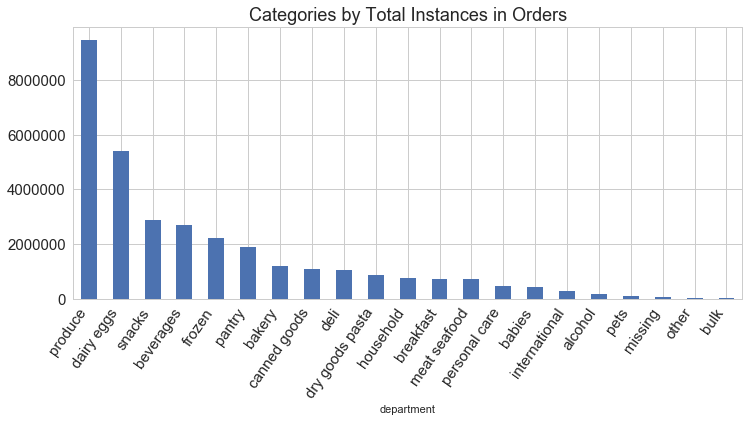

In [10]:
# Total Number of Instances of each Category in Prior Order Set
# e.g. order_id 2 has 5 'pantry' items, order_id 3 has 0 'pantry' items, etc. 

fig, ax = plt.subplots(figsize=(12, 5))
market_basket_prior.groupby(['department']).size().sort_values(ascending=False
                                                   ).plot(kind='bar',
                                                          fontsize=15)
ax.ticklabel_format(axis='y', style='plain')
plt.xticks(ha='right', rotation=55)
plt.title("Categories by Total Instances in Orders", fontsize=18);

dept_totals = pd.DataFrame(market_basket_prior.groupby(['department']
                                                      ).size().sort_values(ascending=False))
dept_totals.columns = ['Totals']
dept_totals.head(10)

,Totals
product_name,
Banana,472565
Bag of Organic Bananas,379450
Organic Strawberries,264683
Organic Baby Spinach,241921
Organic Hass Avocado,213584
Organic Avocado,176815
Large Lemon,152657
Strawberries,142951
Limes,140627


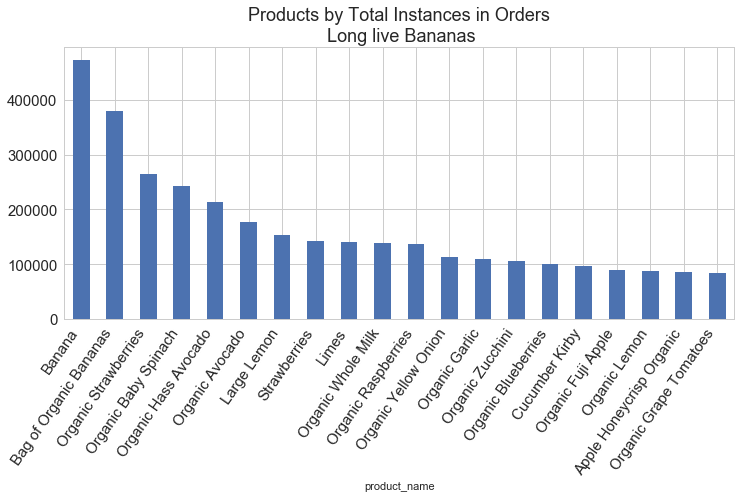

In [11]:
# Popular products by total order count

fig, ax = plt.subplots(figsize=(12, 5))
market_basket_prior.groupby(['product_name']).size().sort_values(ascending=False
                                                   )[:20].plot(kind='bar',
                                                               fontsize=15)
ax.ticklabel_format(axis='y', style='plain')
plt.xticks(ha='right', rotation=55)
plt.title("Products by Total Instances in Orders\n Long live Bananas", fontsize=18);

product_totals = pd.DataFrame(market_basket_prior.groupby(['product_name']).size().sort_values(ascending=False))
product_totals.columns = ['Totals']
product_totals.head(10)
